In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc
from lightgbm import LGBMClassifier
import numpy as np
from xgboost import XGBClassifier

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
origin = pd.read_csv('origin.csv')

In [ ]:
origin.rename(columns = {'RowNumber':'id'}, inplace=True)

In [ ]:
test_id = test['id']

In [ ]:
def drop_useless(df):
    df.drop(['id', 'CustomerId', 'Surname'], axis=1, inplace=True)
    return df

In [ ]:
drop_useless(train)
drop_useless(origin)
drop_useless(test)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,586,France,Female,23.0,2,0.00,2,0.0,1.0,160976.75
1,683,France,Female,46.0,2,0.00,1,1.0,0.0,72549.27
2,656,France,Female,34.0,7,0.00,2,1.0,0.0,138882.09
3,681,France,Male,36.0,8,0.00,1,1.0,0.0,113931.57
4,752,Germany,Male,38.0,10,121263.62,1,1.0,0.0,139431.00
...,...,...,...,...,...,...,...,...,...,...
110018,570,Spain,Male,29.0,7,116099.82,1,1.0,1.0,148087.62
110019,575,France,Female,36.0,4,178032.53,1,1.0,1.0,42181.68
110020,712,France,Male,31.0,2,0.00,2,1.0,0.0,16287.38
110021,709,France,Female,32.0,3,0.00,1,1.0,1.0,158816.58


In [ ]:
# train과 원본 데이터 병합
train = pd.concat([train, origin], ignore_index=True)

# 중복 열 제거
train.drop_duplicates(inplace=True)

In [ ]:
# 각 열의 최빈값(mode)을 구하고 이를 딕셔너리에 저장
mode_values_train = train.mode().iloc[0]

# 각 열의 결측치를 해당 열의 최빈값으로 대체
train.fillna(mode_values_train, inplace=True)

# test에 대해서 동일하게 적용
mode_values_test = test.mode().iloc[0]
test.fillna(mode_values_test, inplace=True)

In [ ]:
# 범주형 데이터를 구분 후 각각의 변수에 저장
# train과 test 두 데이터에 대해 각각 적용
num_cols = list(train.select_dtypes(exclude=['object']).columns)

num_cols_test = list(test.select_dtypes(exclude=['object']).columns)

# Encoding이 필요하지 않은 경우 저장하지 않음
num_cols = [col for col in num_cols if col not in ['Exited', 'IsActiveMember', 'HasCrCard']]
num_cols_test = [col for col in num_cols_test if col not in ['Exited', 'IsActiveMember', 'HasCrCard']]

In [ ]:
# 두 방법 중 하나 선택 후 비교
# StandardScaler를 통해 수치형 데이터를 표준화
# scaler = StandardScaler()
# train[num_cols] = scaler.fit_transform(train[num_cols])
# test[num_cols_test] = scaler.transform(test[num_cols_test])

# MinMaxScaler 통해 수치형 데이터를 표준화 - 조금 더 높은 성능을 보임
scaler = MinMaxScaler()
train[num_cols] = scaler.fit_transform(train[num_cols])
test[num_cols_test] = scaler.transform(test[num_cols_test])

In [ ]:
labelencoder = LabelEncoder()
train['Gender']=labelencoder.fit_transform(train['Gender'])
test['Gender']=labelencoder.fit_transform(test['Gender'])

In [ ]:
# Geography OneHotEncoding
train = pd.get_dummies(train, columns=['Geography'])
test = pd.get_dummies(test, columns=['Geography'])

In [ ]:
X = train.drop('Exited', axis=1)
y = train['Exited']

In [ ]:
# 훈련 데이터 분할
X_train, X_valid, y_train, y_valid = train_test_split(X,y,test_size=0.2,random_state=42)

In [ ]:
param_grid = {
     'max_depth': [5, 6, 7],
     'learning_rate': [0.1, 0.5, 1],
     'gamma': [1.0, 1.5, 2],
     'reg_lambda': [10.0, 25.0,50.0],
     'scale_pos_weight': [5, 7, 9]
}

model = GridSearchCV(estimator=XGBClassifier(), param_grid=param_grid, scoring='roc_auc', verbose=3, n_jobs=10, cv=3)
model.fit(X_train, y_train)

#best_params = {'gamma': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'reg_lambda': 25.0, 'scale_pos_weight': 5}

Fitting 3 folds for each of 243 candidates, totalling 729 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=10,
             param_grid={'gamma': [1.0, 1.5, 2], 'learning_rate': [0.1, 0.5, 1],
                         'max_depth': [5, 6, 7],
                         'reg_lambda': [10.0, 25.0, 50.0],
                         'scale_pos_weight': [5, 7, 9]},
             scoring='roc_auc', verbose=3)

In [ ]:
print("Best parameters:", model.best_params_)

Best parameters: {'gamma': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'reg_lambda': 25.0, 'scale_pos_weight': 5}


In [ ]:
best_model = XGBClassifier(**model.best_params_)
best_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1.0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
br = best_model.predict_proba(test)

In [ ]:
y_pred = best_model.predict(X_valid)
accuracy_score(y_valid, y_pred)

0.7782076634281948

In [ ]:
best_result = best_model.predict_proba(test)[:, 1]

In [ ]:
sub = pd.DataFrame()
sub['id'] = test_id

In [ ]:
sub['Exited'] = best_result

In [ ]:
xgb = XGBClassifier()
cb = CatBoostClassifier()
lg = LGBMClassifier()

In [ ]:
xgb.fit(X_train, y_train)
cb.fit(X_train, y_train)
lg.fit(X_train, y_train)

In [ ]:
y_score_xgb = xgb.predict_proba(X_valid)[:, 1]
y_score_cb = cb.predict_proba(X_valid)[:, 1]
y_score_lg = lg.predict_proba(X_valid)[:, 1]

In [ ]:
fpr_xgb, tpr_xgb, _ = roc_curve(y_valid, y_score_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

fpr_cb, tpr_cb, _ = roc_curve(y_valid, y_score_cb)
roc_auc_cb = auc(fpr_cb, tpr_cb)

fpr_lg, tpr_lg, _ = roc_curve(y_valid, y_score_lg)
roc_auc_lg = auc(fpr_lg, tpr_lg)

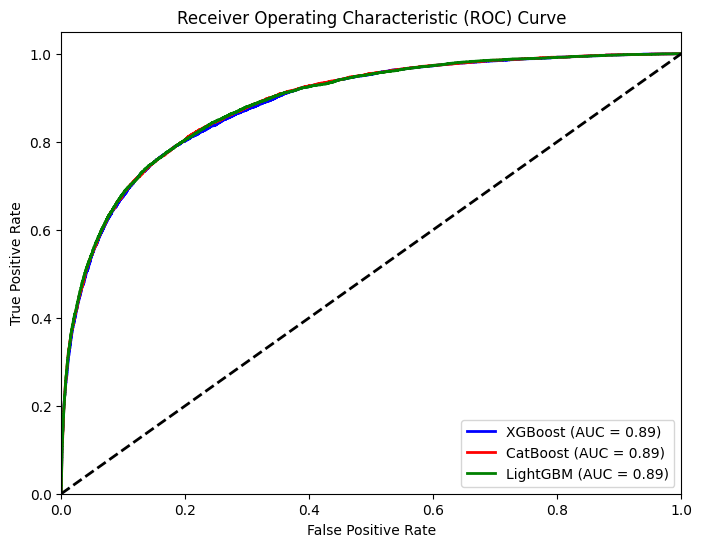

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, color='blue', lw=2, label='XGBoost (AUC = %0.2f)' % roc_auc_xgb)
plt.plot(fpr_cb, tpr_cb, color='red', lw=2, label='CatBoost (AUC = %0.2f)' % roc_auc_cb)
plt.plot(fpr_lg, tpr_lg, color='green', lw=2, label='LightGBM (AUC = %0.2f)' % roc_auc_lg)

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()